In [1]:
n=10000
m=10
p=3 #Barabasi-Albert parameter
init_Theta=0.05#0.06
N=10 #number of time steps
r=0 #0.3 #szansa aktywacji przy negatywnej korelacji
prob=0.20 #prawd. aktywności użytkownika w danej epidemii (do generaowania macierzy)
a=0.15#0.04 # parameter kształtu powr-law

In [2]:
%matplotlib inline

import copy
import math
import pandas as pd
import matplotlib
import numpy as np
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import scipy.sparse as sparse
import asizeof
from collections import defaultdict
G=nx.barabasi_albert_graph(n, p)
print('1.Undirected graph done!')
G=G.to_directed()
print('2.Directed graph done!')
for u,v in tqdm(G.edges()):
    G[u][v]['weight']=1.0#np.random.uniform(0,1)
print('3.Wieghts assigned!')
for i in tqdm(range(n)):
    in_degree=G.in_degree(i,weight='weight')
    for u,v in G.in_edges(i):
        #print(u,v,G[u][v]['weight'],G[u][v]['weight'] / in_degree, in_degree)
        G[u][v]['weight']/=in_degree
print('4.Wieghts normalized!')
W=nx.adjacency_matrix(G,weight='weight')
print('4.Adjacency (sparse) matrix created!')

1.Undirected graph done!
2.Directed graph done!


HBox(children=(IntProgress(value=0, max=59982), HTML(value='')))


3.Wieghts assigned!


HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))


4.Wieghts normalized!
4.Adjacency (sparse) matrix created!


In [3]:
C = np.random.random((m, m))
C=C*2-1
C *= np.tri(*C.shape,k=-1)
C=C+np.transpose(C)+np.eye(m)
print(C.min(),C.max(),C.mean(),np.median(C))
print("Correlation matrix done!")

-0.994266497306 1.0 0.110504583142 0.2423320624
Correlation matrix done!


In [4]:
indykatory=[]
frakcje=[]
import scipy.stats as stats
frac_inf=np.ceil(stats.powerlaw.rvs(a,size=(m))*n).astype(int)
I=np.full((n, m), False, dtype=bool)
for i in tqdm(range(m)):
    I[np.ix_(stats.randint.rvs(0, n-1, size=frac_inf[i]),[i])]=True
indykatory.append(I)
frakcje.append(np.vstack((range(m),np.sum(I,axis=0)/n)))
I=copy.deepcopy(I)
print("Initial state assigned!")

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Initial state assigned!


In [5]:
Theta=np.full((n,m), init_Theta)
print("Initial Theta assigned!")

Initial Theta assigned!


In [6]:
Y=np.full((n,1),0)
print("Activation counter initiated!")

Activation counter initiated!


In [7]:
df=[]
for l in tqdm(range(N)):    
    U=W.transpose().dot(I)
    F=U.dot(C)/m
    #print(F.min(),F.max(),F.mean(),l)
    temp=np.greater_equal(F, Theta) #porównanie funkcji aktywacji z progiem
    ### dodawanie rekordów bez przekroczenia progu
    for i in np.unique(np.where(temp[:,:]==False)[0]):
        temp1=np.where(temp[i,:]==False)[0] #tagi, w których dla użytkownika i przekroczony nie był próg
        temp2=np.where(I[i][:]==True)[0] #tagi juz aktywne
        temp1=np.setdiff1d(temp1,temp2) #usuniecie juz aktywnych tagow
        for j in temp1:
            df.append([i,copy.deepcopy(F[i][j]),0,copy.deepcopy(Y[i][0])])
    ###
    for i in np.unique(np.where(temp[:,:]==True)[0]): #iteracja po użytkownikach, którzy mają przekroczony próg
        temp1=np.where(temp[i,:]==True)[0] #tagi, w których dla użytkownika i przekroczony był próg
        temp2=np.where(I[i][:]==True)[0] #tagi juz aktywne
        temp1=np.setdiff1d(temp1,temp2) #usuniecie juz aktywnych tagow
    ### dodawanie rekordów z przekroczeniem progów
        for j in temp1:
            df.append([i,copy.deepcopy(F[i][j]),1,copy.deepcopy(Y[i][0])])
    ### 
        if (not np.any(C[temp1[:, None],temp1]<0)) and (not temp1.size==0): #sprawdzenie, czy kandydaci do aktywacji nie są negatywnie skorelowani
            I[i][temp1]=True #aktywacja uzytkownika i w tagach z listy temp1
            Y[i][0]+=1#Y[i]+=1 #zwiekszenie licznika aktywacji uzytkownika i
            Theta[i]=1-math.pow(1-init_Theta,Y[i][0]+1) #aktualizacja thety
        else:
            if (np.random.rand()<r) and (not temp1.size==0): #aktywacji pomimo negatywnej korelacji z pr. r
                I[i][temp1]=True
                Y[i][0]+=1
                Theta[i]=1-math.pow(1-init_Theta,Y[i][0]+1)
                if temp1.size==0:
                    print('empty!')
    indykatory.append(I)
    frakcje.append(np.vstack((range(m),np.sum(I,axis=0)/n)))
    I=copy.deepcopy(I)
del temp

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

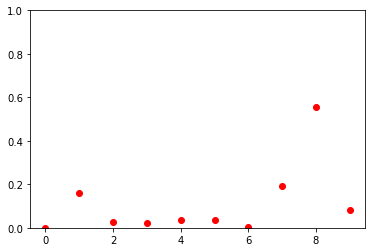

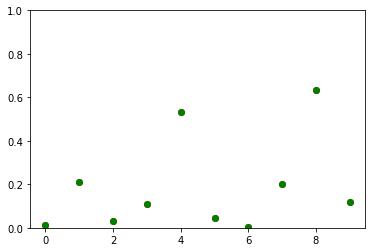

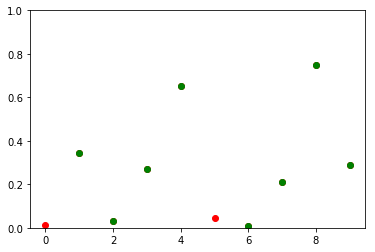

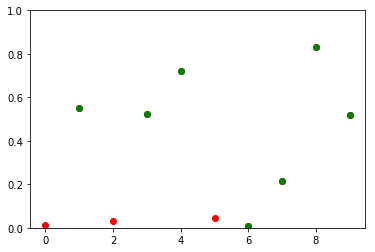

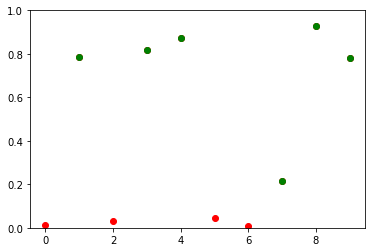

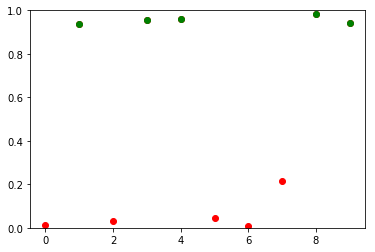

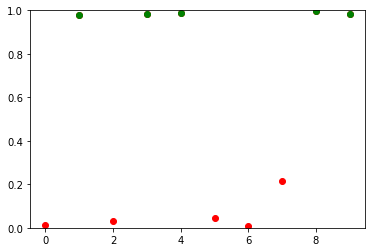

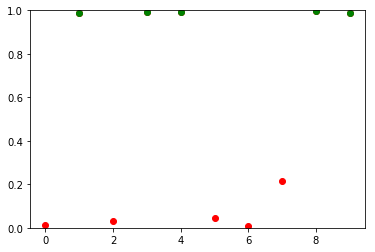

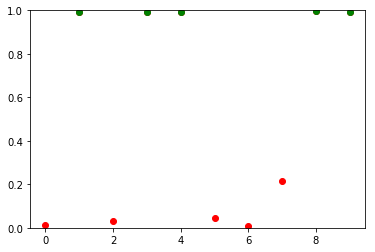

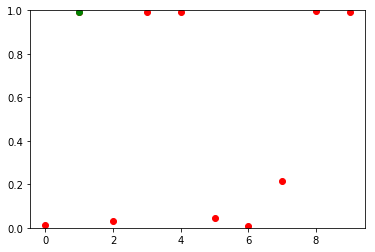

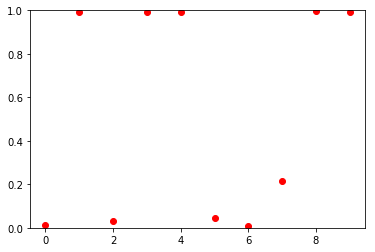

In [8]:
for i in range(N+1):
    plt.plot(frakcje[i][1], 'ro')
    axes = plt.gca()
    axes.set_ylim([0,1])
    if i>0:
        wzrost=frakcje[i][np.ix_([0,1],np.where(frakcje[i]>frakcje[i-1])[1])]
        plt.plot(wzrost[0],wzrost[1], 'go')
    plt.show()

In [9]:
for i in range(N):
    if np.array_equal(indykatory[i],indykatory[i+1])==True:
        print(i)

9


In [10]:
import pandas as pd
df=pd.DataFrame(df)
df.columns=['user','x','y','w']

In [11]:
df.head()

,user,x,y,w
0,0,0.040087,0,0
1,0,0.019085,0,0
2,0,-0.033555,0,0
3,0,0.032062,0,0
4,0,0.029864,0,0


## Logistic Regression

In [12]:
from pandas import DataFrame
from sklearn import preprocessing
from numpy import loadtxt, where
from pylab import scatter, show, legend, xlabel, ylabel

##The sigmoid function adjusts the cost function hypotheses to adjust the algorithm proportionally for worse estimations
def Sigmoid(z):
    G_of_Z = float(1.0 / float((1.0 + math.exp(-1.0*z))))
    return G_of_Z

##The hypothesis is the linear combination of all the known factors x[i] and their current estimated coefficients theta[i] 
##This hypothesis will be used to calculate each instance of the Cost Function
def Hypothesis(theta, x, w):
    z = x-(1-math.pow((1-theta),w+1))
    return Sigmoid(z)

##For each member of the dataset, the result (Y) determines which variation of the cost function is used
##The Y = 0 cost function punishes high probability estimations, and the Y = 1 it punishes low scores
##The "punishment" makes the change in the gradient of ThetaCurrent - Average(CostFunction(Dataset)) greater
def Cost_Function(X,Y,W,theta,m):
    sumOfErrors = 0
    for i in range(m):
        hi = Hypothesis(theta,X[i],W[i])
        error=Y[i]*math.log(hi)+(1-Y[i])*math.log(1-hi)
        sumOfErrors += error
    const = -1/m
    J = const * sumOfErrors
    return J

##This function creates the gradient component for each Theta value 
##The gradient is the partial derivative by Theta of the current value of theta minus 
##a "learning speed factor aplha" times the average of all the cost functions for that theta
##For each Theta there is a cost function calculated for each member of the dataset
def Cost_Function_Derivative(X,Y,W,theta,m,alpha):
    sumErrors = 0
    for i in range(m):
        xi = X[i]
        wi = W[i]
        hi = Hypothesis(theta,xi,wi)
        error = -1.0*(hi - Y[i])
        sumErrors += error
    constant = float(alpha)/float(m)
    J = constant * sumErrors

    return J


##For each theta, the partial differential 
##The gradient, or vector from the current point in Theta-space (each theta value is its own dimension) to the more accurate point, 
##is the vector with each dimensional component being the partial differential for each theta value
def Gradient_Descent(X,Y,W,theta,m,alpha,w):
    constant = alpha/m
    CFDerivative = Cost_Function_Derivative(X,Y,W,theta,m,alpha)
    #if type(CFDerivative)==list:
    #    CFDerivative=CFDerivative[0] 
    new_theta = 1-math.pow((1-math.pow((1-theta),float(w+1)))+CFDerivative,1/float(w+1))
    return [new_theta, CFDerivative]

##The high level function for the LR algorithm which, for a number of steps (num_iters) finds gradients which take 
##the Theta values (coefficients of known factors) from an estimation closer (new_theta) to their "optimum estimation" which is the
##set of values best representing the system in a linear combination model
def Logistic_Regression(X,Y,W,alpha,theta,num_iters,w):
    m = len(Y)
    cost=[Cost_Function(X,Y,W,theta,m)]
    Theta=[theta]
    gradient=[0]
    for x in range(num_iters):
        GD = Gradient_Descent(X,Y,W,theta,m,alpha,w)
        theta = GD[0]
        gradient.append(GD[1])
        cost.append(Cost_Function(X,Y,W,theta,m))
        Theta.append(theta)
        if abs(GD[1])<0.00001:
            break
        #if x % 100 == 0:
            #here the cost function is used to present the final hypothesis of the model in the same form for each gradient-step iteration
            #print("theta ", theta, " at ",x,"-th iteration")
            #print("cost is ", Cost_Function(X,Y,W,theta,m))
    return [Theta,cost,gradient]

In [13]:
from joblib import Parallel, delayed
import time
def text_progessbar(seq, total=None):
    step = 1
    tick = time.time()
    while True:
        time_diff = time.time()-tick
        avg_speed = time_diff/step
        total_str = 'of %n' % total if total else ''
        print('user', step, '%.2f' % time_diff, 'avg: %.2f iter/sec' % avg_speed, total_str)
        step += 1
        yield next(seq)
all_bar_funcs = {
    'txt': lambda args: lambda x: text_progessbar(x, **args),
    'None': lambda args: iter,
}
def ParallelExecutor(use_bar='tqdm', **joblib_args):
    def aprun(bar=use_bar, **tq_args):
        def tmp(op_iter):
            if str(bar) in all_bar_funcs.keys():
                bar_func = all_bar_funcs[str(bar)](tq_args)
            else:
                raise ValueError("Value %s not supported as bar type"%bar)
            return Parallel(**joblib_args)(bar_func(op_iter))
        return tmp
    return aprun
n_jobs=22
aprun = ParallelExecutor(n_jobs=n_jobs)

## Data preprocessing

In [14]:
def Estimate_theta(df,user,initial_theta,alpha,num_iters,w):
    #print(initial_theta)
    X=df[df['user']==user]
    Y=X['y']
    Y=np.array(Y)#.reshape(-1, 1)
    W=X['w']
    W=np.array(W)#.reshape(-1, 1)
    #print('srednia z W to ',np.mean(W))
    X=X['x']
    X=np.array(X).reshape(-1, 1)
    mini=X.min(axis=0)
    maxi=X.max(axis=0)
    X=((X - mini) / (maxi - mini))*2-1
    LR=Logistic_Regression(X,Y,alpha,initial_theta,num_iters)
    LR[0]=[(x+1)/2*(maxi-mini)+mini for x in LR[0]]
    return LR

In [15]:
initial_theta = 0
alpha = 0.01
iterations = 100
user=5
w=10
Estimate_theta(df,user,initial_theta,alpha,iterations,w)[0][iterations]

0.005307781119568644

user 1 0.00 avg: 0.00 iter/sec 
user 2 0.00 avg: 0.00 iter/sec 
user 3 0.00 avg: 0.00 iter/sec 
user 4 0.00 avg: 0.00 iter/sec 
user 5 0.01 avg: 0.00 iter/sec 
user 6 0.01 avg: 0.00 iter/sec 
user 7 0.01 avg: 0.00 iter/sec 
user 8 0.01 avg: 0.00 iter/sec 
user 9 0.02 avg: 0.00 iter/sec 
user 10 0.02 avg: 0.00 iter/sec 
user 11 0.02 avg: 0.00 iter/sec 
user 12 0.02 avg: 0.00 iter/sec 
user 13 0.02 avg: 0.00 iter/sec 
user 14 0.02 avg: 0.00 iter/sec 
user 15 0.03 avg: 0.00 iter/sec 
user 16 0.04 avg: 0.00 iter/sec 
user 17 0.04 avg: 0.00 iter/sec 
user 18 0.04 avg: 0.00 iter/sec 
user 19 0.04 avg: 0.00 iter/sec 
user 20 0.04 avg: 0.00 iter/sec 
user 21 0.05 avg: 0.00 iter/sec 
user 22 0.05 avg: 0.00 iter/sec 
user 23 0.05 avg: 0.00 iter/sec 
user 24 0.05 avg: 0.00 iter/sec 
user 25 0.05 avg: 0.00 iter/sec 
user 26 0.06 avg: 0.00 iter/sec 
user 27 0.06 avg: 0.00 iter/sec 
user 28 0.06 avg: 0.00 iter/sec 
user 29 0.06 avg: 0.00 iter/sec 
user 30 0.06 avg: 0.00 iter/sec 
user 31 0.07 avg: 0

user 240 95.70 avg: 0.40 iter/sec 
user 241 96.01 avg: 0.40 iter/sec 
user 242 97.89 avg: 0.40 iter/sec 
user 243 98.24 avg: 0.40 iter/sec 
user 244 99.01 avg: 0.41 iter/sec 
user 245 99.91 avg: 0.41 iter/sec 
user 246 100.55 avg: 0.41 iter/sec 
user 247 100.68 avg: 0.41 iter/sec 
user 248 101.30 avg: 0.41 iter/sec 
user 249 101.50 avg: 0.41 iter/sec 
user 250 101.58 avg: 0.41 iter/sec 
user 251 101.73 avg: 0.41 iter/sec 
user 252 101.80 avg: 0.40 iter/sec 
user 253 102.44 avg: 0.40 iter/sec 
user 254 102.48 avg: 0.40 iter/sec 
user 255 102.99 avg: 0.40 iter/sec 
user 256 103.85 avg: 0.41 iter/sec 
user 257 104.56 avg: 0.41 iter/sec 
user 258 104.63 avg: 0.41 iter/sec 
user 259 104.74 avg: 0.40 iter/sec 
user 260 105.44 avg: 0.41 iter/sec 
user 261 105.64 avg: 0.40 iter/sec 
user 262 105.95 avg: 0.40 iter/sec 
user 263 106.17 avg: 0.40 iter/sec 
user 264 106.43 avg: 0.40 iter/sec 
user 265 108.58 avg: 0.41 iter/sec 
user 266 109.82 avg: 0.41 iter/sec 
user 267 110.04 avg: 0.41 iter/sec

user 468 203.46 avg: 0.43 iter/sec 
user 469 204.09 avg: 0.44 iter/sec 
user 470 204.87 avg: 0.44 iter/sec 
user 471 205.01 avg: 0.44 iter/sec 
user 472 205.18 avg: 0.43 iter/sec 
user 473 206.34 avg: 0.44 iter/sec 
user 474 206.43 avg: 0.44 iter/sec 
user 475 206.47 avg: 0.43 iter/sec 
user 476 207.04 avg: 0.43 iter/sec 
user 477 207.48 avg: 0.43 iter/sec 
user 478 207.65 avg: 0.43 iter/sec 
user 479 208.15 avg: 0.43 iter/sec 
user 480 208.42 avg: 0.43 iter/sec 
user 481 208.66 avg: 0.43 iter/sec 
user 482 208.90 avg: 0.43 iter/sec 
user 483 209.03 avg: 0.43 iter/sec 
user 484 209.98 avg: 0.43 iter/sec 
user 485 210.64 avg: 0.43 iter/sec 
user 486 210.68 avg: 0.43 iter/sec 
user 487 210.74 avg: 0.43 iter/sec 
user 488 211.05 avg: 0.43 iter/sec 
user 489 211.27 avg: 0.43 iter/sec 
user 490 214.18 avg: 0.44 iter/sec 
user 491 214.96 avg: 0.44 iter/sec 
user 492 215.06 avg: 0.44 iter/sec 
user 493 215.74 avg: 0.44 iter/sec 
user 494 215.92 avg: 0.44 iter/sec 
user 495 216.24 avg: 0.44 it

user 696 308.38 avg: 0.44 iter/sec 
user 697 308.59 avg: 0.44 iter/sec 
user 698 308.79 avg: 0.44 iter/sec 
user 699 310.37 avg: 0.44 iter/sec 
user 700 311.44 avg: 0.44 iter/sec 
user 701 312.08 avg: 0.45 iter/sec 
user 702 313.38 avg: 0.45 iter/sec 
user 703 313.49 avg: 0.45 iter/sec 
user 704 314.68 avg: 0.45 iter/sec 
user 705 314.72 avg: 0.45 iter/sec 
user 706 314.76 avg: 0.45 iter/sec 
user 707 315.03 avg: 0.45 iter/sec 
user 708 315.31 avg: 0.45 iter/sec 
user 709 315.44 avg: 0.44 iter/sec 
user 710 316.16 avg: 0.45 iter/sec 
user 711 316.54 avg: 0.45 iter/sec 
user 712 317.16 avg: 0.45 iter/sec 
user 713 317.22 avg: 0.44 iter/sec 
user 714 317.26 avg: 0.44 iter/sec 
user 715 317.30 avg: 0.44 iter/sec 
user 716 317.58 avg: 0.44 iter/sec 
user 717 318.92 avg: 0.44 iter/sec 
user 718 319.47 avg: 0.44 iter/sec 
user 719 320.04 avg: 0.45 iter/sec 
user 720 320.16 avg: 0.44 iter/sec 
user 721 320.21 avg: 0.44 iter/sec 
user 722 320.33 avg: 0.44 iter/sec 
user 723 323.17 avg: 0.45 it

user 924 416.22 avg: 0.45 iter/sec 
user 925 417.12 avg: 0.45 iter/sec 
user 926 417.81 avg: 0.45 iter/sec 
user 927 417.98 avg: 0.45 iter/sec 
user 928 418.56 avg: 0.45 iter/sec 
user 929 418.98 avg: 0.45 iter/sec 
user 930 419.30 avg: 0.45 iter/sec 
user 931 419.66 avg: 0.45 iter/sec 
user 932 419.98 avg: 0.45 iter/sec 
user 933 420.11 avg: 0.45 iter/sec 
user 934 420.98 avg: 0.45 iter/sec 
user 935 421.05 avg: 0.45 iter/sec 
user 936 421.10 avg: 0.45 iter/sec 
user 937 422.37 avg: 0.45 iter/sec 
user 938 422.97 avg: 0.45 iter/sec 
user 939 423.10 avg: 0.45 iter/sec 
user 940 423.94 avg: 0.45 iter/sec 
user 941 424.66 avg: 0.45 iter/sec 
user 942 425.23 avg: 0.45 iter/sec 
user 943 425.51 avg: 0.45 iter/sec 
user 944 425.73 avg: 0.45 iter/sec 
user 945 426.13 avg: 0.45 iter/sec 
user 946 426.72 avg: 0.45 iter/sec 
user 947 426.84 avg: 0.45 iter/sec 
user 948 427.10 avg: 0.45 iter/sec 
user 949 427.62 avg: 0.45 iter/sec 
user 950 428.40 avg: 0.45 iter/sec 
user 951 428.55 avg: 0.45 it

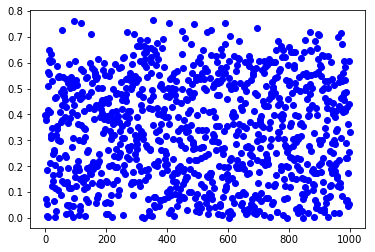

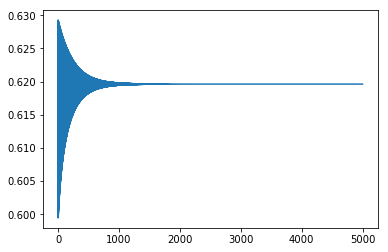

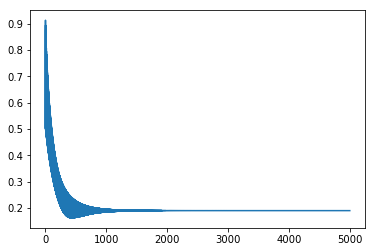

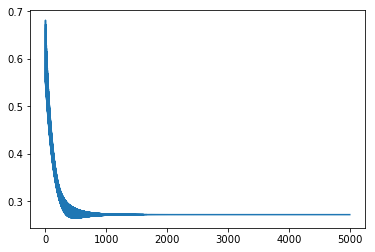

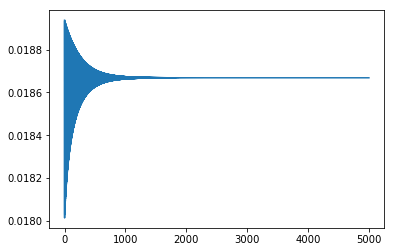

In [25]:
initial_theta = np.random.random_sample(1000)/10
alpha = 0.01
iterations = 5000
w=10 ### JAKI WYKŁADNIK W GRADIENCIE???
results=aprun(bar='txt')(delayed(Estimate_theta)(df,i,initial_theta[i],alpha,iterations,w) for i in range(1000))
est_theta=[]
cost=[]
hist_theta=[]
gradient=[]
for i in range(1000):
    est_theta.append(results[i][0][100])
    hist_theta.append(results[i][0])
    cost.append(results[i][1])
    gradient.append(results[i][2])
plt.plot([np.abs(x - init_Theta)/ init_Theta for x in est_theta],'bo')
plt.show()
plt.plot(np.mean(np.array(cost), axis=0))
plt.show()
dop_theta=[]
for i in range(1000):
    dop_theta.append([np.abs(x - init_Theta)/ init_Theta for x in hist_theta[i]])
plt.plot(np.mean(np.array(dop_theta), axis=0))
plt.show()
for i in range(1000):
    mini=min(dop_theta[i])
    maxi=max(dop_theta[i])
    dop_theta[i]=[(x-mini)/(maxi-mini) for x in dop_theta[i]]
plt.plot(np.mean(np.array(dop_theta), axis=0))
plt.show()
plt.plot(np.mean(np.array(gradient), axis=0)[1:])
plt.show()

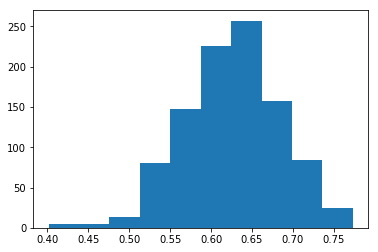

In [17]:
plt.hist(np.array(cost)[:,98])
plt.show()

##### Wykres masymalnego w / liczba aktywnych kampanii na koniec procesu dla wszystkich użytkowników

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


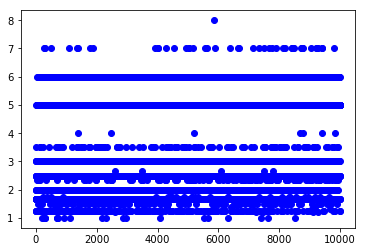

In [18]:
tmp=[]
for i in tqdm(range(df['user'].max()+1)):
    tmp.append(sum(indykatory[N][i,:])/Y[i])
plt.plot(tmp,'bo')
del tmp

#### Różnica pomiędzy liczbą aktywacji z indykatorów, a licznikiem aktywacji

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

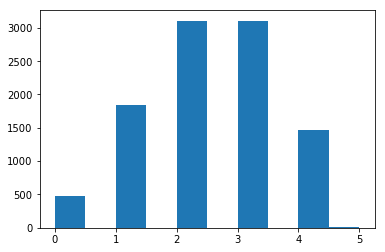

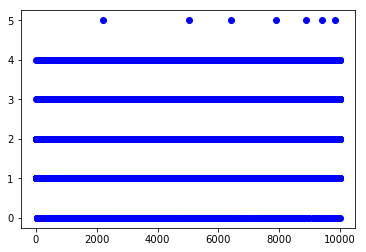

In [19]:
tmp=[]
for i in tqdm(range(n)):
    tmp.append(sum(np.logical_xor(indykatory[N][i,:],indykatory[0][i,:]))-Y[i][0])
    #if sum(np.logical_xor(indykatory[N][i,:],indykatory[0][i,:]))-Y[i][0]<0:
     #   print(i)
plt.hist(tmp)
plt.show()
plt.plot(tmp,'bo')
plt.show()
del tmp